In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import itertools
import sklearn 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import math

In [3]:
from imblearn.over_sampling import SMOTE;
from imblearn.over_sampling import SMOTENC;
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from dmba import classificationSummary, gainsChart, liftChart
import xgboost as xgb

Preprocess the data

In [4]:
df_claims = pd.read_csv("E:\\UAlbany\\Studies\\ITM 603 Business Analytics and Data Mining\\Project\\Dataset\\train.csv")

In [5]:
df_claims.isnull().sum()

policy_id                           0
policy_tenure                       0
age_of_car                          0
age_of_policyholder                 0
area_cluster                        0
population_density                  0
make                                0
segment                             0
model                               0
fuel_type                           0
max_torque                          0
max_power                           0
engine_type                         0
airbags                             0
is_esc                              0
is_adjustable_steering              0
is_tpms                             0
is_parking_sensors                  0
is_parking_camera                   0
rear_brakes_type                    0
displacement                        0
cylinder                            0
transmission_type                   0
gear_box                            0
steering_type                       0
turning_radius                      0
length      

In [6]:
df_claims = df_claims.drop('policy_id', axis=1)

In [7]:
df_claims['torque_Nm'] = df_claims['max_torque'].str.extract(r"([-+]?[0-9]*\.?[0-9]+)(?=\s*Nm)").astype('Float64')
df_claims['torque_rpm'] = df_claims['max_torque'].str.extract(r"([-+]?[0-9]*\.?[0-9]+)(?=\s*rpm)").astype('Float64')
df_claims['power_bhp'] = df_claims['max_power'].str.extract(r"([-+]?[0-9]*\.?[0-9]+)(?=\s*bhp)").astype('Float64')
df_claims['power_rpm'] = df_claims["max_power"].str.extract(r"([-+]?[0-9]*\.?[0-9]+)(?=\s*rpm)").astype('Float64')

In [8]:
df_claims['max_torque_ratio'] = df_claims['torque_Nm']/df_claims['torque_rpm']

In [9]:
df_claims['max_power_ratio'] = df_claims['power_bhp']/df_claims['power_rpm']

In [10]:
df_claims = df_claims.drop(columns=['max_torque','max_power','torque_Nm','torque_rpm','power_bhp','power_rpm'], axis = 1)

In [11]:
df_claims

,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,engine_type,...,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim,max_torque_ratio,max_power_ratio
0,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,F8D Petrol Engine,...,No,Yes,No,No,No,Yes,0,0,0.017143,0.006727
1,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,F8D Petrol Engine,...,No,Yes,No,No,No,Yes,0,0,0.017143,0.006727
2,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,F8D Petrol Engine,...,No,Yes,No,No,No,Yes,0,0,0.017143,0.006727
3,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,1.2 L K12N Dualjet,...,Yes,Yes,Yes,Yes,Yes,Yes,2,0,0.025682,0.01475
4,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,1.0 SCe,...,Yes,Yes,No,Yes,Yes,Yes,2,0,0.021412,0.012193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58587,0.355089,0.13,0.644231,C8,8794,2,A,M3,Petrol,1.0 SCe,...,Yes,Yes,No,Yes,Yes,Yes,2,0,0.021412,0.012193
58588,1.199642,0.02,0.519231,C14,7788,1,A,M1,CNG,F8D Petrol Engine,...,No,Yes,No,No,No,Yes,0,0,0.017143,0.006727
58589,1.162273,0.05,0.451923,C5,34738,1,A,M1,CNG,F8D Petrol Engine,...,No,Yes,No,No,No,Yes,0,0,0.017143,0.006727
58590,1.236307,0.14,0.557692,C8,8794,1,B2,M6,Petrol,K Series Dual jet,...,Yes,Yes,Yes,Yes,Yes,Yes,2,0,0.025682,0.01475


In [12]:
df_claims = df_claims.replace({'No':0, 'Yes':1})

In [13]:
df_claims = pd.get_dummies(df_claims, df_claims.select_dtypes(include=['object']).columns, prefix_sep='_', drop_first=True )

In [14]:
df_claims

,policy_tenure,age_of_car,age_of_policyholder,population_density,make,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,...,engine_type_1.5 Turbocharged Revotron,engine_type_F8D Petrol Engine,engine_type_G12B,engine_type_K Series Dual jet,engine_type_K10C,engine_type_i-DTEC,rear_brakes_type_Drum,transmission_type_Manual,steering_type_Manual,steering_type_Power
0,0.515874,0.05,0.644231,4990,1,2,0,0,0,1,...,False,True,False,False,False,False,True,True,False,True
1,0.672619,0.02,0.375000,27003,1,2,0,0,0,1,...,False,True,False,False,False,False,True,True,False,True
2,0.841110,0.02,0.384615,4076,1,2,0,0,0,1,...,False,True,False,False,False,False,True,True,False,True
3,0.900277,0.11,0.432692,21622,1,2,1,1,0,1,...,False,False,False,False,False,False,True,False,False,False
4,0.596403,0.11,0.634615,34738,2,2,0,0,0,0,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58587,0.355089,0.13,0.644231,8794,2,2,0,0,0,0,...,False,False,False,False,False,False,True,False,False,False
58588,1.199642,0.02,0.519231,7788,1,2,0,0,0,1,...,False,True,False,False,False,False,True,True,False,True
58589,1.162273,0.05,0.451923,34738,1,2,0,0,0,1,...,False,True,False,False,False,False,True,True,False,True
58590,1.236307,0.14,0.557692,8794,1,2,0,1,0,1,...,False,False,False,True,False,False,True,True,False,False


Undersampling

In [15]:
all_0s = df_claims[df_claims['is_claim']==0]
all_1s = df_claims[df_claims['is_claim']==1]

uns_0s = resample(all_0s, replace= False, n_samples=round(len(all_1s)*4), random_state=512)
uns_claims_df = pd.concat([uns_0s, all_1s])

In [16]:
uns_claims_df

,policy_tenure,age_of_car,age_of_policyholder,population_density,make,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,...,engine_type_1.5 Turbocharged Revotron,engine_type_F8D Petrol Engine,engine_type_G12B,engine_type_K Series Dual jet,engine_type_K10C,engine_type_i-DTEC,rear_brakes_type_Drum,transmission_type_Manual,steering_type_Manual,steering_type_Power
33394,0.339678,0.00,0.750000,34738,1,2,0,0,0,1,...,False,True,False,False,False,False,True,True,False,True
10553,1.100108,0.05,0.375000,34738,1,2,0,1,0,1,...,False,False,False,True,False,False,True,True,False,False
41543,0.247103,0.02,0.634615,27003,1,2,0,1,0,1,...,False,False,False,True,False,False,True,True,False,False
20966,0.616179,0.06,0.615385,5410,3,6,1,1,1,1,...,False,False,False,False,False,False,False,False,False,True
14984,0.647327,0.02,0.317308,4990,1,2,0,0,0,1,...,False,True,False,False,False,False,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58559,0.484333,0.12,0.596154,8794,1,6,1,1,0,1,...,False,False,False,False,False,False,True,False,False,False
58567,1.148102,0.04,0.451923,34791,3,6,1,1,1,1,...,False,False,False,False,False,False,False,False,False,True
58573,0.151652,0.00,0.365385,4990,1,2,0,0,0,1,...,False,True,False,False,False,False,True,True,False,True
58574,0.278499,0.07,0.557692,5410,3,6,1,1,1,1,...,False,False,False,False,False,False,False,False,False,True


Oversampling

In [17]:
sm = SMOTE(sampling_strategy=1.0, random_state=512)

In [18]:
to_ovs_x = df_claims.drop('is_claim', axis=1)
to_ovs_y = df_claims['is_claim']

In [19]:
ovs_X, ovs_Y = sm.fit_resample(to_ovs_x, to_ovs_y)

In [20]:
ovs_Y.value_counts()

is_claim
0    54844
1    54844
Name: count, dtype: int64

In [21]:
ovs_claims_df = ovs_X

In [22]:
ovs_claims_df['is_claim'] = ovs_Y

In [23]:
ovs_claims_df

,policy_tenure,age_of_car,age_of_policyholder,population_density,make,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,...,engine_type_F8D Petrol Engine,engine_type_G12B,engine_type_K Series Dual jet,engine_type_K10C,engine_type_i-DTEC,rear_brakes_type_Drum,transmission_type_Manual,steering_type_Manual,steering_type_Power,is_claim
0,0.515874,0.050000,0.644231,4990,1,2,0,0,0,1,...,True,False,False,False,False,True,True,False,True,0
1,0.672619,0.020000,0.375000,27003,1,2,0,0,0,1,...,True,False,False,False,False,True,True,False,True,0
2,0.841110,0.020000,0.384615,4076,1,2,0,0,0,1,...,True,False,False,False,False,True,True,False,True,0
3,0.900277,0.110000,0.432692,21622,1,2,1,1,0,1,...,False,False,False,False,False,True,False,False,False,0
4,0.596403,0.110000,0.634615,34738,2,2,0,0,0,0,...,False,False,False,False,False,True,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109683,1.164900,0.086400,0.715000,8794,1,2,0,1,0,1,...,False,False,True,False,False,True,True,False,False,1
109684,0.402119,0.048490,0.438858,8794,1,2,1,1,0,1,...,False,False,False,False,False,True,False,False,False,1
109685,1.100042,0.059691,0.346599,34791,1,2,0,1,0,1,...,False,False,True,False,False,True,True,False,False,1
109686,0.105000,0.096336,0.383264,27003,3,6,1,1,1,1,...,False,False,False,False,False,False,False,False,True,1


Train and Test Split

In [24]:
data_X = uns_claims_df.drop('is_claim', axis=1)
data_Y = uns_claims_df['is_claim']

In [25]:
train_X, valid_X, train_Y, valid_Y = train_test_split(data_X, data_Y, test_size=0.4, random_state=54)

Logistic Regression

In [26]:
logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_Y)
pred_Y = logit_reg.predict(valid_X)

In [27]:
print(classification_report(valid_Y, pred_Y))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      5985
           1       0.00      0.00      0.00      1511

    accuracy                           0.80      7496
   macro avg       0.40      0.50      0.44      7496
weighted avg       0.64      0.80      0.71      7496



e:\UAlbany\Studies\PyBA\venv603\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\UAlbany\Studies\PyBA\venv603\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\UAlbany\Studies\PyBA\venv603\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
print(classificationSummary(valid_Y, pred_Y))

Confusion Matrix (Accuracy 0.7984)

       Prediction
Actual    0    1
     0 5985    0
     1 1511    0
None


Naive Bayes

In [33]:
nb_Gauss = GaussianNB()
nb_Mult = MultinomialNB

Xgboost

ROC (AUC)

In [30]:
Y_prob = logit_reg.predict_proba(valid_X)[:, 1]

In [31]:
fpr, tpr, thresholds = roc_curve(valid_Y, Y_prob)
auc = roc_auc_score(valid_Y, Y_prob)

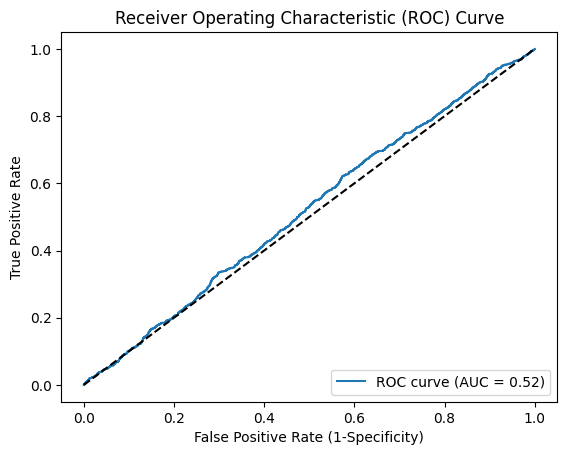

In [32]:
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()